# Описание проекта

Я работаею в IT-компании, которая выполняет на заказ проекты по машинному обучению. Ко мне обратился фермер, владелец молочного хозяйства «Вольный луг». Он хочет купить бурёнок, чтобы расширить поголовье стада коров. Для этого он заключил выгодный контракт с ассоциацией пастбищ «ЭкоФерма».

Условия позволяют фермеру очень тщательно отобрать коров. Он определяет качество молока по строгой методике, и при этом ему нужно выполнять свой план развития молочного хозяйства. Фермер хочет, чтобы каждая бурёнка давала не менее 6000 килограммов молока в год, а надой был вкусным — строго по его критериям, ничуть не хуже. А продавцы и технологи так и норовят приукрасить своих бурёнок!

Поэтому он просит нас разработать модель машинного обучения, которая поможет ему управлять рисками и принимать объективное решение о покупке. «ЭкоФерма» готова предоставить подробные данные о своих коровах. Вам нужно создать две прогнозные модели для отбора бурёнок в поголовье:

Первая будет прогнозировать возможный удой у коровы (целевой признак Удой);
Вторая — рассчитывать вероятность получить вкусное молоко от коровы (целевой признак Вкус молока).

С помощью модели нужно отобрать коров по двум критериям:

1. Средний удой за год — не менее 6000 килограммов,
2. Молоко должно быть вкусным.


Описание данных:



<p>Описание таблицы:</p>
<p><strong>Параметры корма коровы</strong></p>
<ul>
<li>ЭКЕ (Энергетическая кормовая единица) — измерение питательности корма коровы;</li>
<li>Сырой протеин — содержание сырого протеина в корме, в граммах;</li>
<li>СПО (Сахаро-протеиновое соотношение) — отношение сахара к протеину в корме коровы.</li>
</ul>
<p><strong>Где паслась корова</strong><br>Тип пастбища — ландшафт лугов, на которых паслась корова.</p>
<p><strong>Особенности коровы</strong></p>
<ul>
<li><code>id</code> — номер коровы;</li>
<li><code>Порода</code> — порода коровы;</li>
<li><code>Возраст</code> — бинарный признак (<code>менее_2_лет</code>, <code>более_2_лет</code>);</li>
<li><code>Имя Папы</code> — порода папы коровы. Характеристики молока</li>
<li><code>Жирность</code> — содержание жиров в молоке, в процентах;</li>
<li><code>Белок</code> — содержание белков в молоке, в процентах;</li>
<li><code>Вкус молока</code> — оценка вкуса по личным критериям фермера;</li>
<li><code>Удой</code> — масса молока, которую корова даёт в год, в килограммах.</li>
</ul>
<p>Файл <code>ferma_dad.csv</code> хранит имя папы каждой коровы в стаде фермера.<br>Файл <code>cow_buy.csv</code> — это данные о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой. Структура таблицы почти аналогична <code>ferma_main.csv</code>, кроме нескольких особенностей:</p>
<ul>
<li><code>Белок</code> и <code>Жирность</code> молока указаны на момент покупки — когда «ЭкоФерма» давала им свой корм.</li>
<li>Параметры кормления <code>ЭКЕ</code>, <code>Сырой протеин</code>, <code>СПО отсутствуют</code>. Недавно технологи заказчика пересмотрели параметры корма и планируют их внедрить после расширения стада. Именно новые параметры нужно использовать, когда вы будете применять предсказательные модели к бурёнкам «ЭкоФермы». По новой схеме фермер планирует увеличить средние значения <code>ЭКЕ</code>, <code>Сырой протеин</code>, <code>СПО</code> на 5%.</li>



# Импорт библиотек

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score,  confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score

# Считывание файлов

In [2]:
data_ferma_main = pd.read_csv("https://code.s3.yandex.net/datasets/ferma_main.csv", sep=';', index_col='id')
data_ferma_main.shape

(634, 11)

In [3]:
data_ferma_main.head()

,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
id,,,,,,,,,,,
1,5863,"14,2",1743,"0,89",Вис Бик Айдиал,Равнинное,Айдиал,"3,58","3,076",вкусно,более_2_лет
2,5529,"12,8",2138,"0,89",Вис Бик Айдиал,Равнинные,Соверин,"3,54","3,079",вкусно,менее_2_лет
3,5810,14,1854,"0,885",РефлешнСоверинг,Холмистое,Соверин,"3,59","3,074",не вкусно,более_2_лет
4,5895,"12,4",2012,"0,885",РефлешнСоверинг,Холмистое,Айдиал,"3,4","3,075",не вкусно,более_2_лет
5,5302,"12,8",1675,"0,885",Вис Бик Айдиал,Равнинные,Соверин,"3,73","3,073",вкусно,менее_2_лет


In [4]:
data_ferma_dad =  pd.read_csv("https://code.s3.yandex.net/datasets/ferma_dad.csv", sep=';', index_col='id')
data_ferma_dad.shape

(629, 1)

In [5]:
data_ferma_dad.head()

,Имя Папы
id,
1,Буйный
2,Соловчик
3,Барин
4,Буйный
5,Барин


In [6]:
data_cow_buy =  pd.read_csv("https://code.s3.yandex.net/datasets/cow_buy.csv", sep=';')
data_cow_buy.shape

(20, 7)

In [7]:
data_cow_buy.head()

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,"3,54","3,081",менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,"3,4","3,061",более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,"3,64","3,074",более_2_лет


# Предобработка данных

<h2><code>data_ferma_main</code></h2>

In [8]:
data_ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
Index: 634 entries, 1 to 627
Data columns (total 11 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   Удой, кг                               634 non-null    int64 
 1   ЭКЕ (Энергетическая кормовая единица)  634 non-null    object
 2   Сырой протеин, г                       634 non-null    int64 
 3   СПО (Сахаро-протеиновое соотношение)   634 non-null    object
 4   Порода                                 634 non-null    object
 5   Тип пастбища                           634 non-null    object
 6   порода папы_быка                       634 non-null    object
 7   Жирность,%                             634 non-null    object
 8   Белок,%                                634 non-null    object
 9   Вкус молока                            634 non-null    object
 10  Возраст                                634 non-null    object
dtypes: int64(2), object(9)
m

Переведем названия столбцов к нижнему регистру, пробелы заменим на _.

In [9]:
data_ferma_main.columns = data_ferma_main.columns.str.lower().str.replace(' ', '_')

Уберем громоздкие названия

In [10]:
data_ferma_main.rename(
    columns={
        'эке_(энергетическая_кормовая_единица)':'эке',
        'сырой_протеин,_г':'сырой_протеин',
        'удой,_кг':'удой',
        'спо_(сахаро-протеиновое_соотношение)':'спо',
        'жирность,%':'жирность',
        'белок,%':'белок',
        }, inplace=True)

<h3>Обработка пропусков:</h3>

In [11]:
data_ferma_main.isna().sum()

,0
удой,0
эке,0
сырой_протеин,0
спо,0
порода,0
тип_пастбища,0
порода_папы_быка,0
жирность,0
белок,0
вкус_молока,0


Пропусков нет

<h3>Поиск дубликатов:</h3>

In [12]:
data_ferma_main.duplicated().sum()

5

In [13]:
data_ferma_main[data_ferma_main.duplicated(keep=False)]

,удой,эке,сырой_протеин,спо,порода,тип_пастбища,порода_папы_быка,жирность,белок,вкус_молока,возраст
id,,,,,,,,,,,
627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет
627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет
627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет
627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет
627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет
627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет


Последние 5 строк являются полными дубликатами коровы с `id` 627. Удалим их.

In [14]:
data_ferma_main = data_ferma_main.drop_duplicates()

Проверим на ошибки записи в столбцах: `Тип пастбища`, `порода папы_быка`, `Порода`.

Заметим, что в типах пастбищ есть `Равнинное` и `Равнинные`.

In [15]:
data_ferma_main['тип_пастбища'].unique()

array(['Равнинное', 'Равнинные', 'Холмистое'], dtype=object)

Приведём к единому названию - `Равнинное`.

In [16]:
data_ferma_main.loc[data_ferma_main['тип_пастбища']=='Равнинные','тип_пастбища'] = 'Равнинное'

Также переведём к нижнему регистру.

In [17]:
data_ferma_main.loc[:,'тип_пастбища'] = data_ferma_main['тип_пастбища'].str.lower()

Заметим, что в типах пастбищ есть `Айдиал` и `Айдиалл`.

In [18]:
data_ferma_main['порода_папы_быка'].unique()

array(['Айдиал', 'Соверин', 'Айдиалл'], dtype=object)

Приведём к единому названию - `Айдиал`.

In [19]:
data_ferma_main.loc[data_ferma_main['порода_папы_быка']=='Айдиалл','порода_папы_быка'] = 'Айдиал'

In [20]:
data_ferma_main['порода'].unique()

array(['Вис Бик Айдиал', 'РефлешнСоверинг'], dtype=object)

В столбце Порода ошибок нет.

<h3>Изменение типов данных:</h3>

Перевод в численные столбцы:

In [21]:
data_ferma_main['эке'] = pd.to_numeric(
    data_ferma_main['эке'].str.replace(',', '.')
    )

In [22]:
data_ferma_main['спо'] = pd.to_numeric(
    data_ferma_main['спо'].str.replace(',', '.')
    )

In [23]:
data_ferma_main['жирность'] = pd.to_numeric(
    data_ferma_main['жирность'].str.replace(',', '.')
    )

In [24]:
data_ferma_main['белок'] = pd.to_numeric(
    data_ferma_main['белок'].str.replace(',', '.')
    )

<h2><code>data_ferma_dad</code></h2>

In [25]:
data_ferma_dad.info()

<class 'pandas.core.frame.DataFrame'>
Index: 629 entries, 1 to 629
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Имя Папы  629 non-null    object
dtypes: object(1)
memory usage: 9.8+ KB


Переведем названия столбцов к нижнему регистру и пробелы заменим на _.

In [26]:
data_ferma_dad.columns = data_ferma_dad.columns.str.lower().str.replace(' ', '_')

<h3>Обработка пропусков:</h3>

In [27]:
data_ferma_dad.isna().sum()

,0
имя_папы,0


Пропусков нет

<h2><code>data_cow_buy</code></h2>

In [28]:
data_cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Порода                   20 non-null     object
 1   Тип пастбища             20 non-null     object
 2   порода папы_быка         20 non-null     object
 3   Имя_папы                 20 non-null     object
 4   Текущая_жирность,%       20 non-null     object
 5   Текущий_уровень_белок,%  20 non-null     object
 6   Возраст                  20 non-null     object
dtypes: object(7)
memory usage: 1.2+ KB


Переведем названия столбцов к нижнему регистру и пробелы заменим на _.

In [29]:
data_cow_buy.columns = data_cow_buy.columns.str.lower().str.replace(' ', '_')

Таже переименуем столбцы `текущая_жирность,%` и `текущий_уровень_белок,%` на `жирность,%` и `белок,%`

In [30]:
data_cow_buy.rename(columns={'текущая_жирность,%':'жирность','текущий_уровень_белок,%':'белок'}, inplace=True)

<h3>Обработка пропусков:</h3>

In [31]:
data_cow_buy.isna().sum()

,0
порода,0
тип_пастбища,0
порода_папы_быка,0
имя_папы,0
жирность,0
белок,0
возраст,0


Пропусков нет

<h3>Поиск дубликатов:</h3>

In [32]:
data_cow_buy.duplicated().sum()

4

In [33]:
data_cow_buy[data_cow_buy.duplicated(keep=False)]

,порода,тип_пастбища,порода_папы_быка,имя_папы,жирность,белок,возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,"3,64","3,074",более_2_лет
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
8,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
14,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
19,РефлешнСоверинг,равнинное,Айдиал,Буйный,"3,64","3,074",более_2_лет


Теоретически возможно полное совпадение всех параметров, если это 2 коровы, родившиеся от одного отца. Но точное совпадение жирности и уровня белка слишком маловероятно.

Целесообразнее будет написать в службу поддержки Экофермы для разъясненея. Но удалять данные не будем, т.к. с этими данными будут производиться только предсказания, следовательно на качество модели это никак не повлияет.

<h3>Изменение типов данных:</h3>

Перевод в численные столбцы:

In [34]:
data_cow_buy['жирность'] = pd.to_numeric(data_cow_buy['жирность'].str.replace(',', '.'))

In [35]:
data_cow_buy['белок'] = pd.to_numeric(data_cow_buy['белок'].str.replace(',', '.'))

Проверим на ошибки записи в столбцах: `Тип пастбища`, `порода папы_быка`, `Порода`.

In [36]:
data_cow_buy['тип_пастбища'].unique()

array(['холмистое', 'равнинное'], dtype=object)

In [37]:
data_cow_buy['порода_папы_быка'].unique()

array(['Айдиал', 'Соверин'], dtype=object)

In [38]:
data_cow_buy['порода'].unique()

array(['Вис Бик Айдиал', 'РефлешнСоверинг'], dtype=object)

Технологи заказчика пересмотрели параметры корма и планируют их внедрить после расширения стада. По новой схеме фермер планирует увеличить средние значения `ЭКЕ`, `Сырой протеин`, `СПО` на 5%.

Найдем средние значения `ЭКЕ`, `Сырой протеин`, `СПО`, увеличим на 5% и заполним этими значениями столбцы в `data_cow`.

In [39]:
mean_EKE = data_ferma_main['эке'].mean()
mean_SP = data_ferma_main['сырой_протеин'].mean()
mean_SPR = data_ferma_main['спо'].mean()

data_cow_buy['эке'] = mean_EKE * 1.05
data_cow_buy['сырой_протеин'] = mean_SP * 1.05
data_cow_buy['спо'] = mean_SPR * 1.05

# Объединение таблиц

<h2>Объеденим в одну таблицу <code>data_ferma</code> информацию про коров и их отцов.</h2>

In [40]:
data_ferma = data_ferma_main.join(data_ferma_dad)

In [41]:
data_ferma.head()

,удой,эке,сырой_протеин,спо,порода,тип_пастбища,порода_папы_быка,жирность,белок,вкус_молока,возраст,имя_папы
id,,,,,,,,,,,,
1,5863,14.2,1743,0.890,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,Буйный
2,5529,12.8,2138,0.890,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,Соловчик
3,5810,14.0,1854,0.885,РефлешнСоверинг,холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,Барин
4,5895,12.4,2012,0.885,РефлешнСоверинг,холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,Буйный
5,5302,12.8,1675,0.885,Вис Бик Айдиал,равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,Барин


# Исследовательский анализ данных

In [42]:
data_ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
Index: 629 entries, 1 to 629
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   удой              629 non-null    int64  
 1   эке               629 non-null    float64
 2   сырой_протеин     629 non-null    int64  
 3   спо               629 non-null    float64
 4   порода            629 non-null    object 
 5   тип_пастбища      629 non-null    object 
 6   порода_папы_быка  629 non-null    object 
 7   жирность          629 non-null    float64
 8   белок             629 non-null    float64
 9   вкус_молока       629 non-null    object 
 10  возраст           629 non-null    object 
dtypes: float64(4), int64(2), object(5)
memory usage: 75.1+ KB


<h2>Посмотрим на числовые данные. Поищем выбросы. </h2>

In [43]:
data_ferma.describe()

,удой,эке,сырой_протеин,спо,жирность,белок
count,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000
mean,6188.750397,14.543879,1923.364070,0.913116,3.603657,3.075671
std,1644.795489,1.306408,182.956251,0.032203,0.168656,0.002549
min,5204.000000,10.900000,1660.000000,0.840000,2.990000,3.069000
25%,5751.000000,13.500000,1771.000000,0.890000,3.590000,3.074000
50%,6133.000000,14.700000,1888.000000,0.930000,3.650000,3.076000
75%,6501.000000,15.600000,2062.000000,0.940000,3.720000,3.077000
max,45616.000000,16.800000,2349.000000,0.960000,3.750000,3.085000


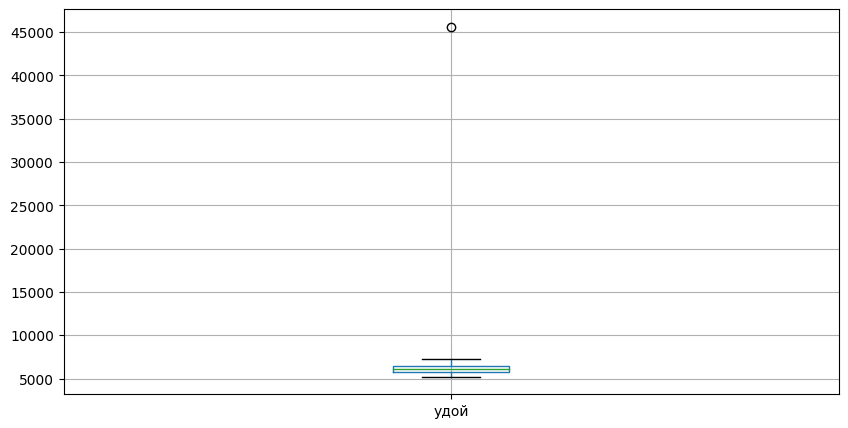

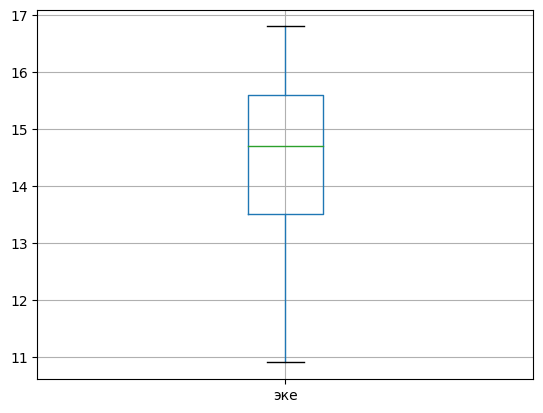

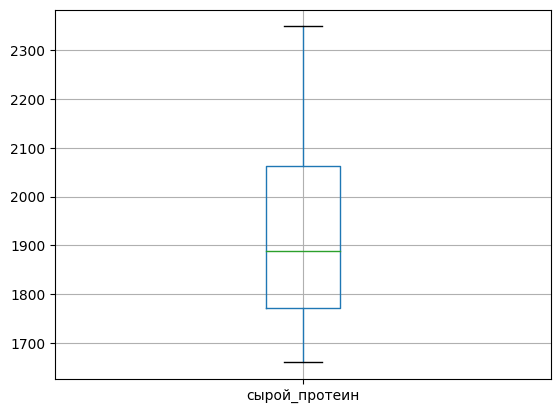

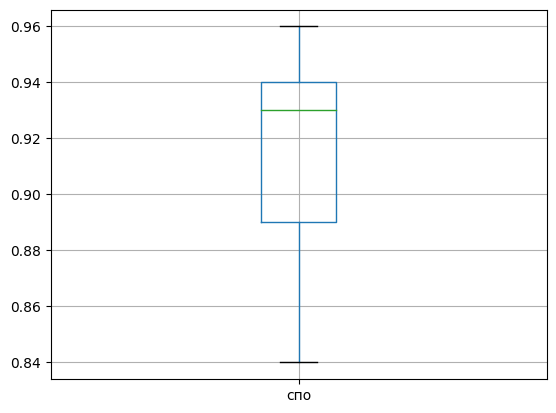

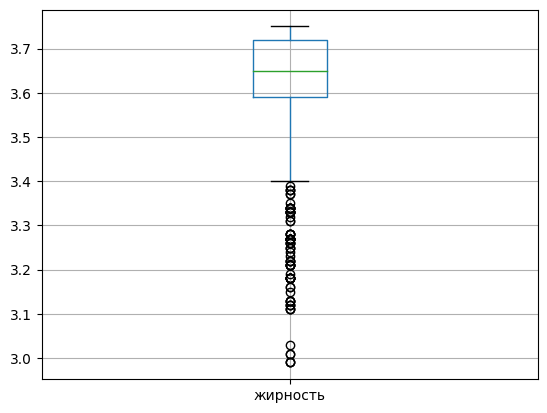

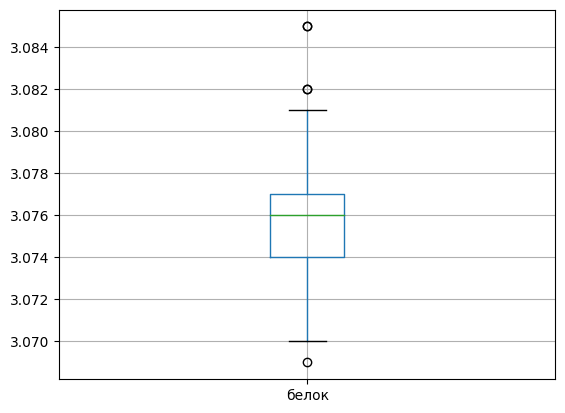

In [44]:
plt.figure(figsize=(10,5))
for col in data_ferma.columns[(data_ferma.dtypes !='object')]:
  data_ferma.boxplot(col)
  plt.show()

Удой в 45000 килограммов выглядит нереалистично и является выбросом.

Вероятнее всего ошибка произошла при заполнении,возможно искомый результат меньше в 10 раз и кто-то поставил лишнюю цифру, однако восстановить данные достоверно мы не можем.

Удалим выброс.

In [45]:
data_ferma = data_ferma[data_ferma['удой']<40000]

В остальном, Аномальные значения в значительном количестве наблюдаются лишь в столбце `Жирность,%`, однако выбросами не являются.

<h2>Построим графики распределения.</h2>


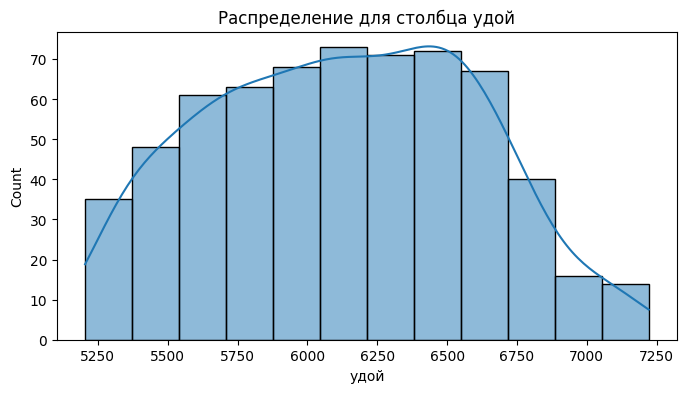

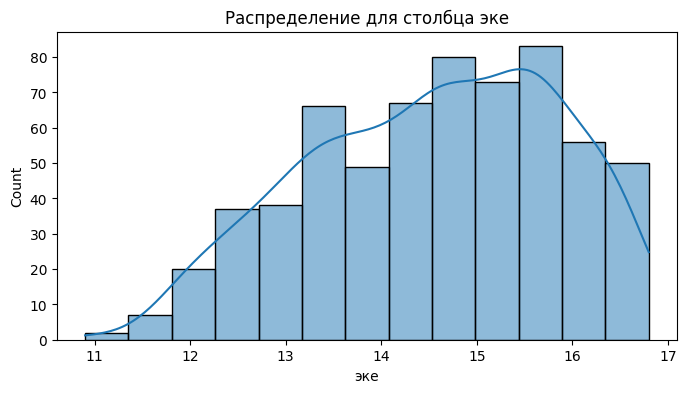

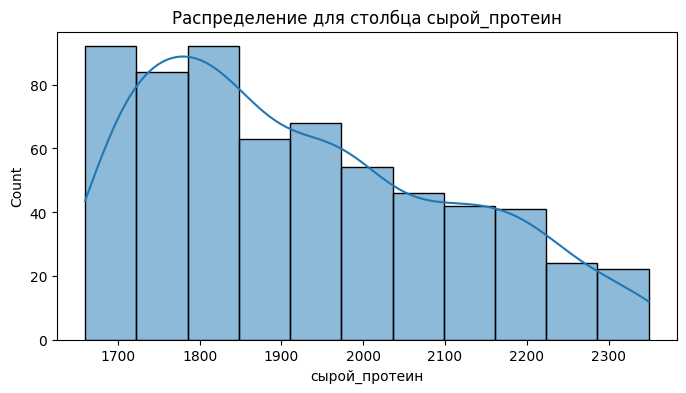

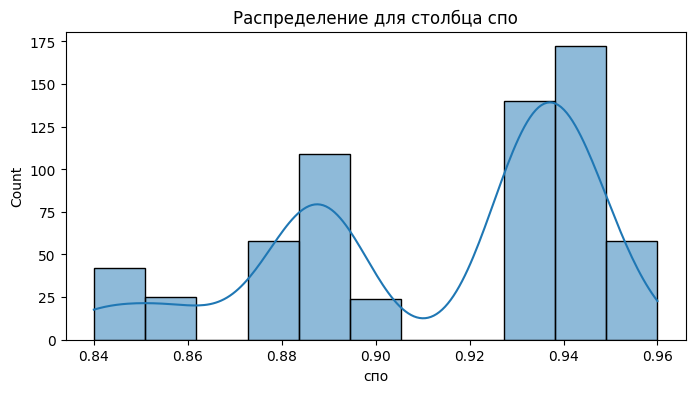

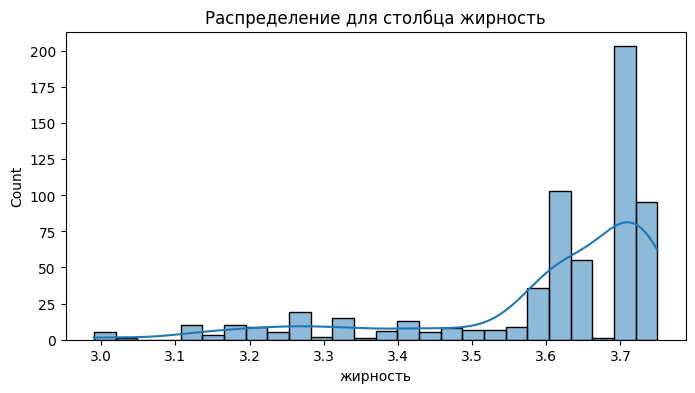

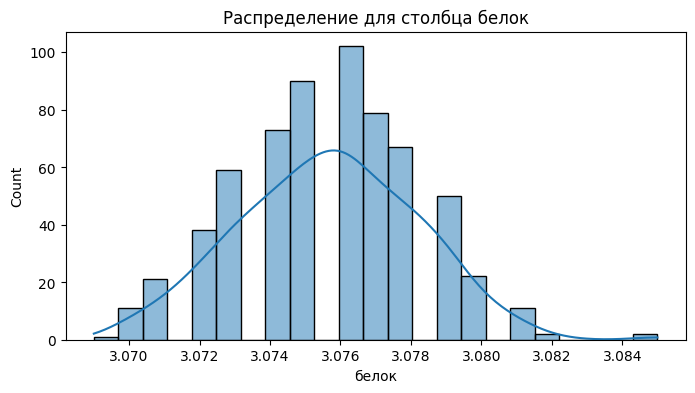

In [46]:
for column in data_ferma.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(data_ferma[column], kde=True)
    plt.title(f'Распределение для столбца {column}')
    plt.show()

Нормальное распределение в столбцах:

* `удой`
* `белок`
* `эке`
* `сырой_протеин`


Ненормальное:

* `спо` - 2 пика
* `жирность` - возрастает практически на всем промежутке, но в конце ведет себя странно.




In [47]:
data_ferma

,удой,эке,сырой_протеин,спо,порода,тип_пастбища,порода_папы_быка,жирность,белок,вкус_молока,возраст,имя_папы
id,,,,,,,,,,,,
1,5863,14.2,1743,0.890,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,Буйный
2,5529,12.8,2138,0.890,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,Соловчик
3,5810,14.0,1854,0.885,РефлешнСоверинг,холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,Барин
4,5895,12.4,2012,0.885,РефлешнСоверинг,холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,Буйный
5,5302,12.8,1675,0.885,Вис Бик Айдиал,равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,Барин
...,...,...,...,...,...,...,...,...,...,...,...,...
625,6812,15.4,1964,0.940,РефлешнСоверинг,равнинное,Айдиал,3.74,3.075,не вкусно,более_2_лет,Буйный
626,5513,12.9,1700,0.880,РефлешнСоверинг,равнинное,Соверин,3.64,3.073,вкусно,менее_2_лет,Барин
627,5970,14.4,1837,0.880,РефлешнСоверинг,холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет,Барин


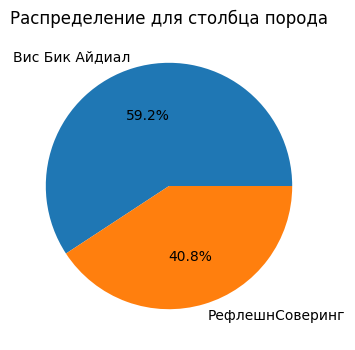

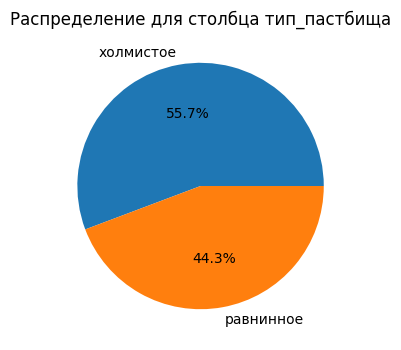

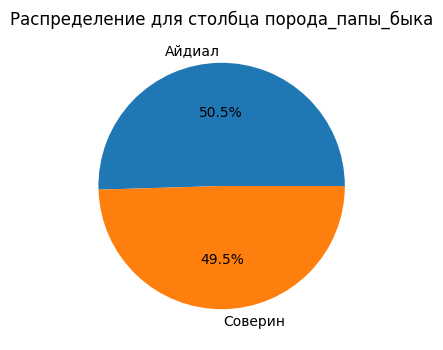

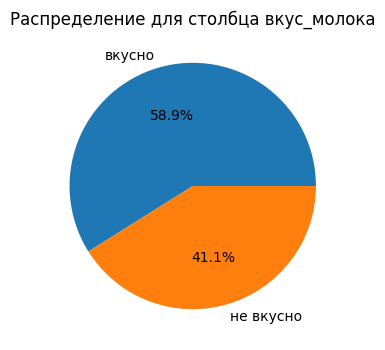

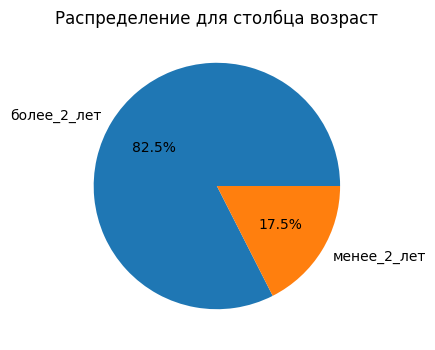

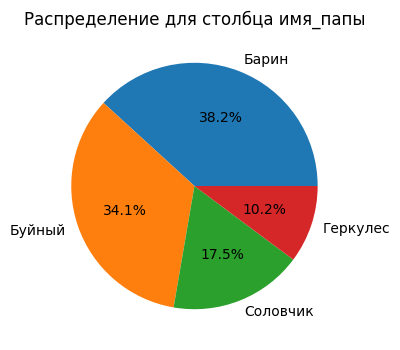

In [48]:
for column in data_ferma.select_dtypes(include=['object']).columns:
    plt.figure(figsize=(8, 4))
    x = data_ferma[column].value_counts()
    plt.pie(x, labels=x.index, autopct='%1.1f%%')
    plt.grid()
    plt.title(f'Распределение для столбца {column}')
    plt.show()

1. Наиболее распространненая порода - Вис Бик Айдиал
2. Наиболее распространненный тип пастбища - холмистое.
3. Порода папы быка распределена поровну между Айдиалом и Соверином.
4. Большинство коров с вкусным молоком.
5. Более 80% коров старше 2 лет.
6. Самые популярные имена папы - Барин и Буйный, непопулярные - Соловчик и Геркулес.

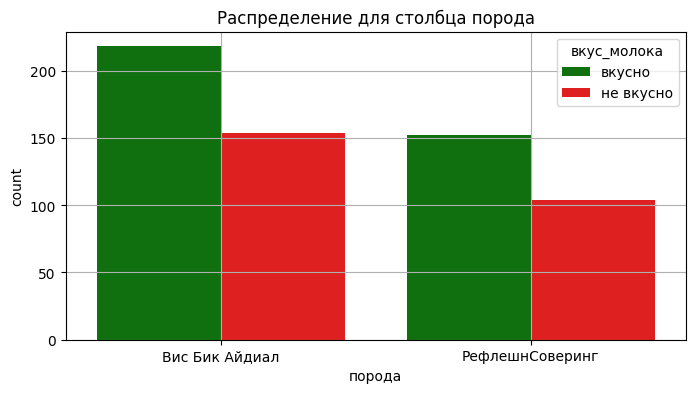

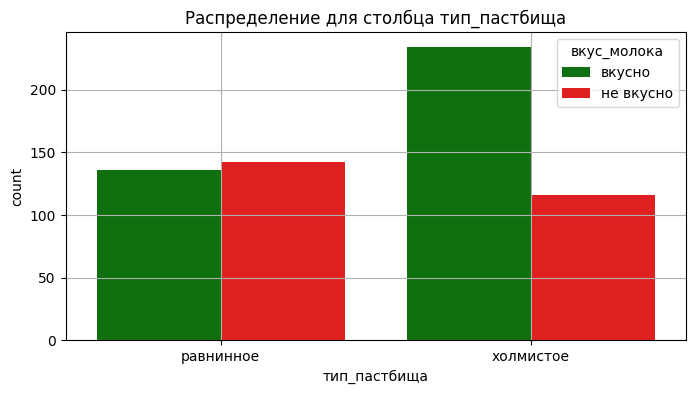

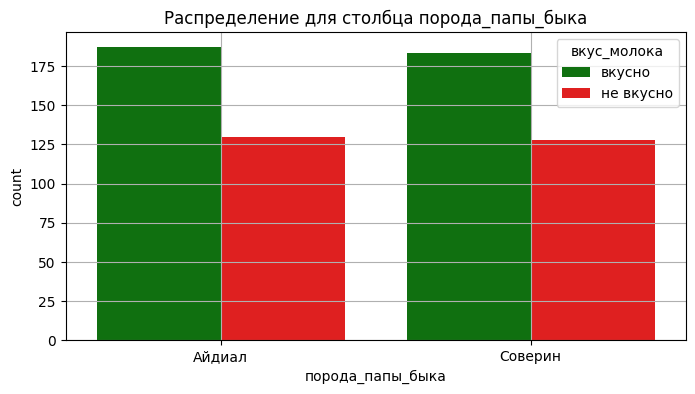

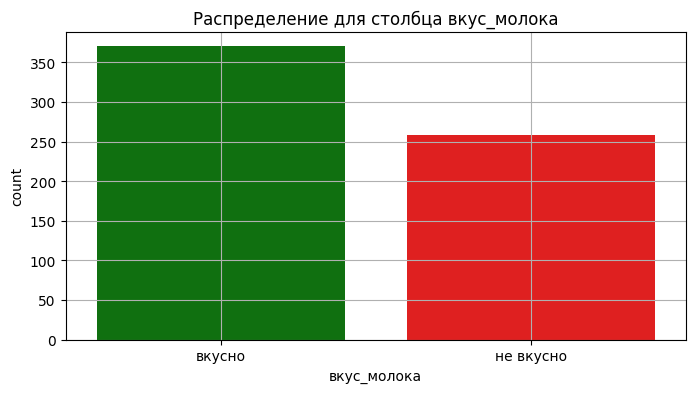

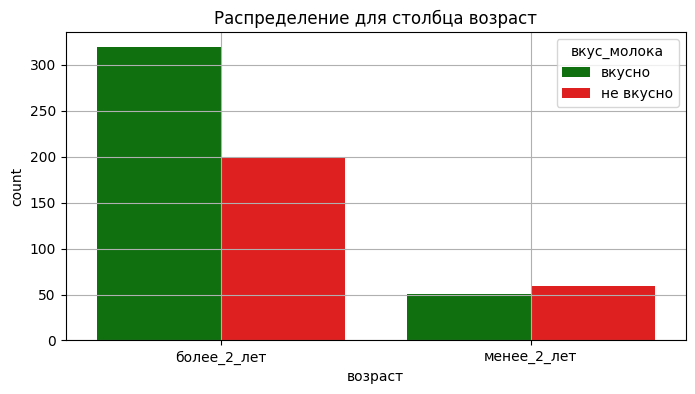

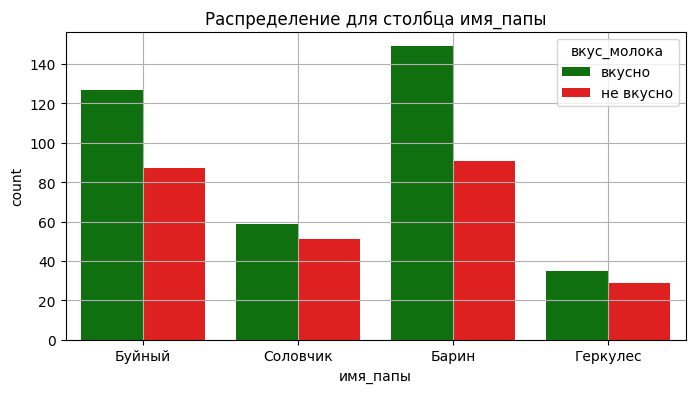

In [49]:
for column in data_ferma.select_dtypes(include=['object']).columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=data_ferma, x=column, hue='вкус_молока', palette = {'вкусно': 'green', 'не вкусно': 'red'})
    plt.grid()
    plt.title(f'Распределение для столбца {column}')
    plt.show()

1. Вкусное молоко встречается чаще невкусного.
2. Вкусное молоко встречается чаще для обеих пород коров.
3. На равнинном типе пастбища молоко практически всегда вкусное, а на холмистом - чуть чаще - невкусное.
4. Вкусное молоко встречается чаще для обеих пород папы быка.
5. У коров, старше 2 лет молоко обычно вкусное. У коров, младше 2 лет - немного чаще невкусное.
6. Молоко чаще вкусное, независимо от имени папы, но коровы с именем папы: Барин и Буйный чаще других приносят вкусное молоко.

# Корреляционный анализ

<h2>Посмотрим на корреляцию</h2>

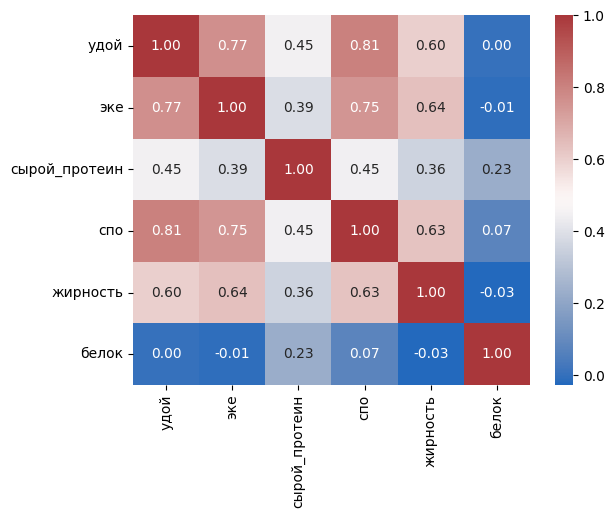

In [50]:
sns.heatmap(data_ferma.corr(numeric_only=True), cmap="vlag", annot=True, fmt="0.2f");

Все переменные, кроме процента белка имеют некую корреляцию между собой.

Наибольшая корреляция Между `удоем`, `спо`, `эке`.

Ненормально распределенные данные - `спо`, `жирность`

In [51]:
data_ferma['удой'].corr(data_ferma['спо'], method='spearman')

0.787904090851949

In [52]:
data_ferma['удой'].corr(data_ferma['жирность'], method='spearman')

0.688505794761783

В среднем, зависимость довольно большая. Но при этом мультиколлинеарности не наблюдается.

Создадим функции `scatterplot` и `barplot` на основе `seaborn` и `matplotlib.pyplot` для автоматизации рутины.

In [53]:
def scatterplot(data: pd.DataFrame, x: str | pd.Series, y: str, title: str, hue: str = None, palette: dict[str: str] = None, xlabel: str = None):
    plt.figure(figsize=(10, 5))
    # Если мы хотим посмотреть зависимость признака, которого нет в data
    # то x: pd.Series
    if isinstance(x, pd.Series):
        sns.scatterplot(x=x, y=data[y], alpha=0.7, s=20, hue=hue, palette=palette)
        plt.xlabel(xlabel)
    else:
        sns.scatterplot(data=data, x=x, y=y, alpha=0.7, s=20, hue=hue, palette=palette)
        plt.xlabel(x)
    plt.title(title)
    plt.ylabel(y)
    plt.grid()
    plt.show()

In [54]:
def barplot(data: pd.DataFrame, x: str, y: str, title: str, ylim: tuple = None, figsize: tuple = (8, 4), hue: str = None, palette: str = None):
    plt.figure(figsize=figsize)
    sns.barplot(data=data, x=x, y=y,errorbar=None,width=0.9, hue=hue, palette = palette)
    plt.title(title)
    plt.grid()
    plt.ylim(ylim)
    plt.show()

<h2>Построим графики зависимости параметров от целевой переменной</h2>

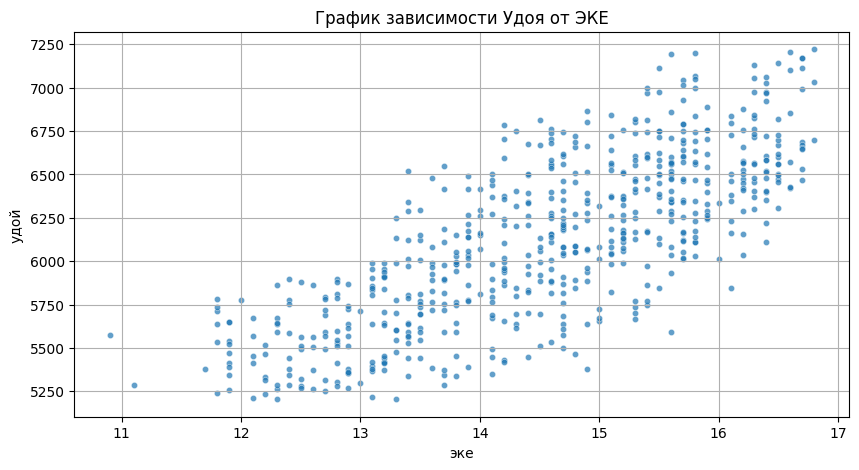

In [55]:
scatterplot(data_ferma, 'эке', 'удой', 'График зависимости Удоя от ЭКЕ')

Зависимость удоя похоже на прямую пропорциональность, но больше похоже на параболу. Посмотрим зависимость от ЭКЕ^2.

С большой точностью можно сказать, что при ЭКЕ больше 15, удой будет больше 6000 кг.

`вкус_молока` при `эке` >16 преимущественно `вкусный`

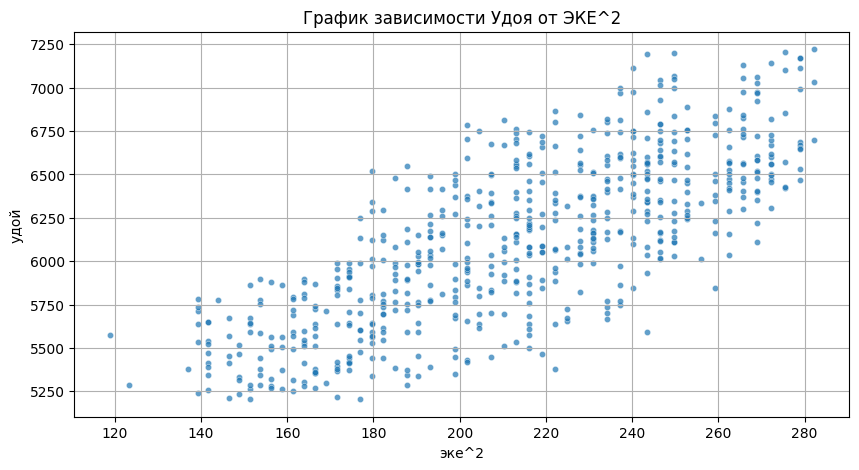

In [56]:
scatterplot(data=data_ferma, x=data_ferma['эке'] ** 2, y='удой', title='График зависимости Удоя от ЭКЕ^2', xlabel = 'эке^2')

Такой график больше похож на прямую пропорциональность.

С большой точностью можно сказать, что при ЭКЕ^2 больше 240, удой будет больше 6000 кг.

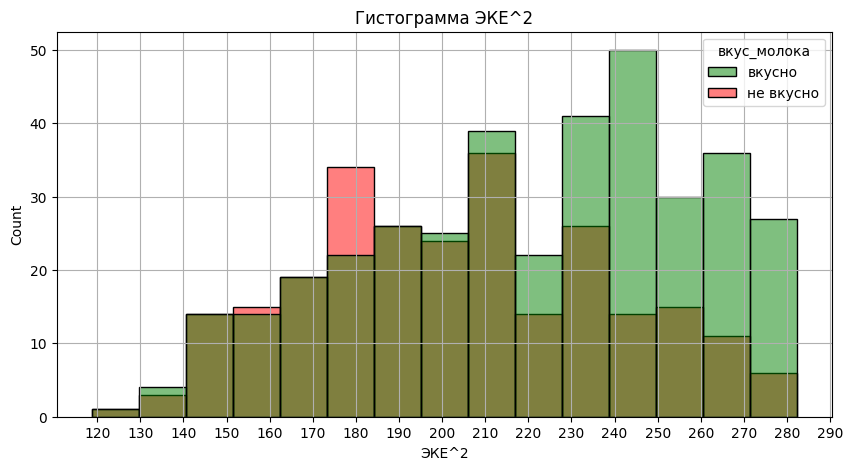

In [57]:
plt.figure(figsize=(10,5))
sns.histplot(data= data_ferma, x=data_ferma['эке'] ** 2, hue='вкус_молока', palette = {'вкусно': 'green', 'не вкусно': 'red'}, bins=15)
plt.xlabel('ЭКЕ^2')
plt.title('Гистограмма ЭКЕ^2')
plt.xticks(range(120,300,10))
plt.grid()
plt.show()

1. При эке^2 до 160 вкусное молоко встречается чуть чаще, чем невкусное.
2. При эке^2 от 160 до 180 больше невкусного молока.
3. При эке^2 от 190 до 200 одинаково часто вкусное и невкусное молоко.
4. ПРи эке^2 более 200 безоговорочно доминирует вкусное молоко.

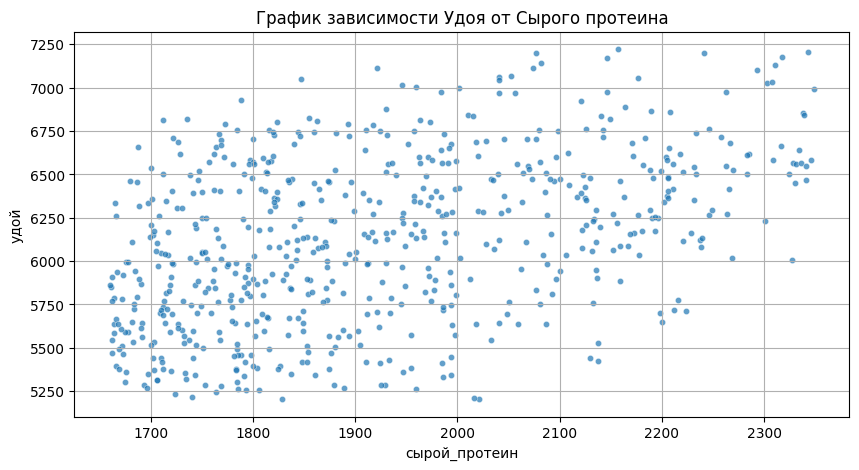

In [58]:
scatterplot(data_ferma, 'сырой_протеин', 'удой','График зависимости Удоя от Сырого протеина')

Тенденции не обнаружено.

Зависимость удоя: c большой точностью можно сказать, что при количестве сырого протеина больше 2200 г, удой будет больше 6000 кг.

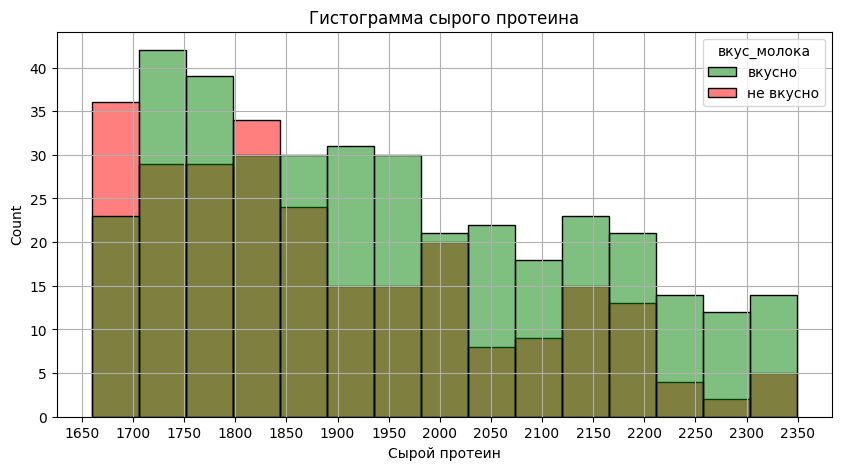

In [59]:
plt.figure(figsize=(10,5))
sns.histplot(data = data_ferma, x='сырой_протеин', hue='вкус_молока', palette = {'вкусно': 'green', 'не вкусно': 'red'}, bins=15)
plt.title('Гистограмма сырого протеина')
plt.xlabel('Сырой протеин')
plt.xticks(range(1650,2400,50))
plt.grid()
plt.show()

1. При сыром протеине от 1650 г. до 1700 г. и от 1800 г. до 1850 г. преобладает невкусное молоко.
2. При сыром протеине около 2000 г. примерно поровну вкусного и невкусного молока.
3. При всех остальных промежутках преобладает вкусное молоко.


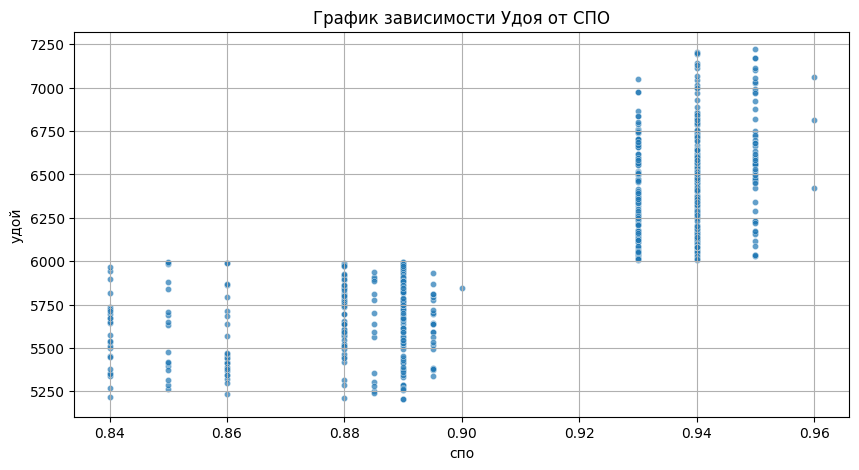

In [60]:
scatterplot(data_ferma, 'спо', 'удой', 'График зависимости Удоя от СПО')

Видим четкое разделение: `спо`<0.91 и `спо`>=0.91

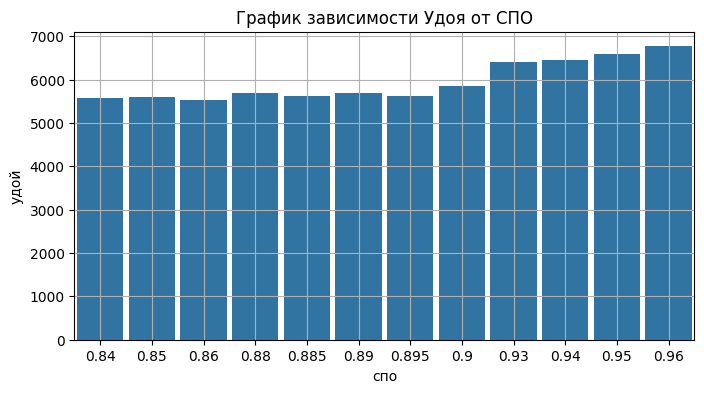

In [61]:
barplot(data_ferma, 'спо', 'удой','График зависимости Удоя от СПО')

С большой точностью можно сказать, что при СПО от 0.93, удой будет больше 6000 кг.

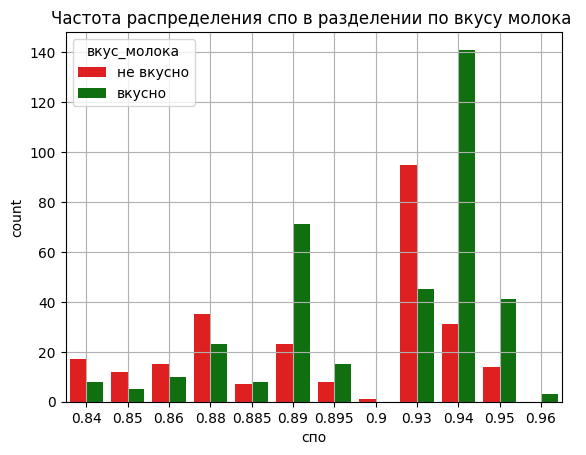

In [62]:
sns.countplot(data=data_ferma, x='спо', hue='вкус_молока',palette = {'вкусно': 'green', 'не вкусно': 'red'})
plt.title('Частота распределения спо в разделении по вкусу молока ')
plt.grid()
plt.show()

1. При спо < 0.89 - молоко чаще невкусное.
2. При спо = 0.93 - молоко в 2 раза чаще невкусное, чем вкусное.
3. При спо <= 0.89 < 0.9 и спо >= 0.94 - молоко практически всегда вкусное.

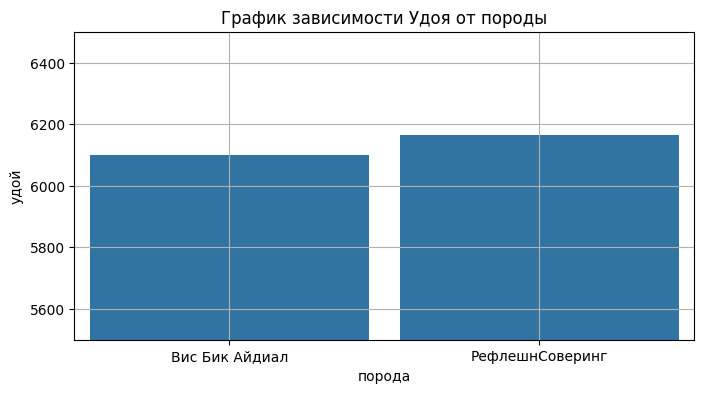

In [63]:
barplot(data_ferma, 'порода', 'удой',title='График зависимости Удоя от породы', ylim=(5500,6500))

Порода `РефлешнСоверинг` в среднем приносит больше удоя. При этом, в среднем обе породы приносят больше 6000 кг удоя.

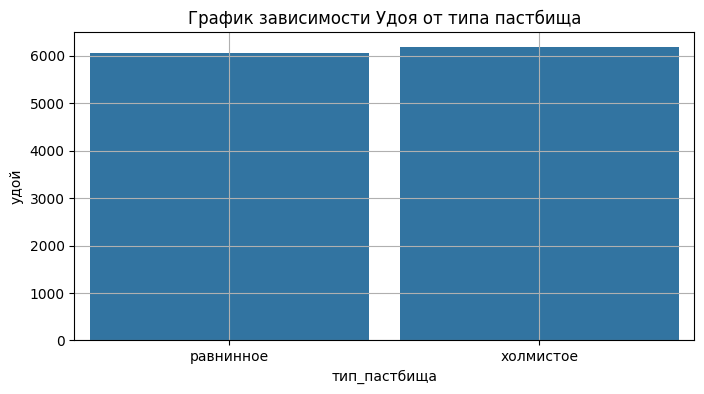

In [64]:
barplot(data_ferma, 'тип_пастбища', 'удой','График зависимости Удоя от типа пастбища')

У коров, пасущихся на холмистой местности удой, в среднем, больше, чем пасущихся на равнинной.

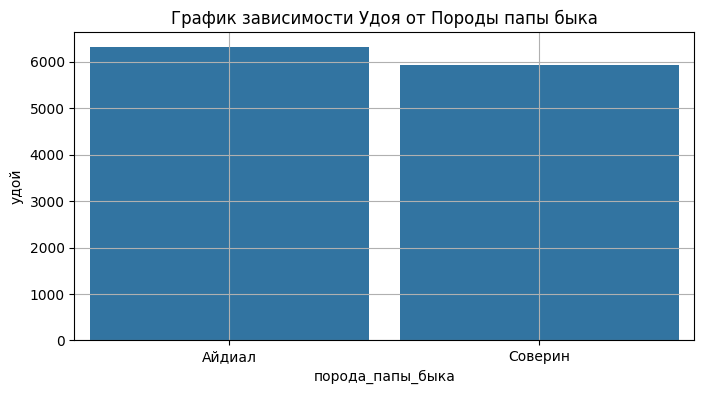

In [65]:
barplot(data_ferma, 'порода_папы_быка', 'удой','График зависимости Удоя от Породы папы быка')


Заметим огромную разницу. Порода папы быка `Айдиал`, в среднем, приносит на 7.6% больше удоя, чем `Соверин`.

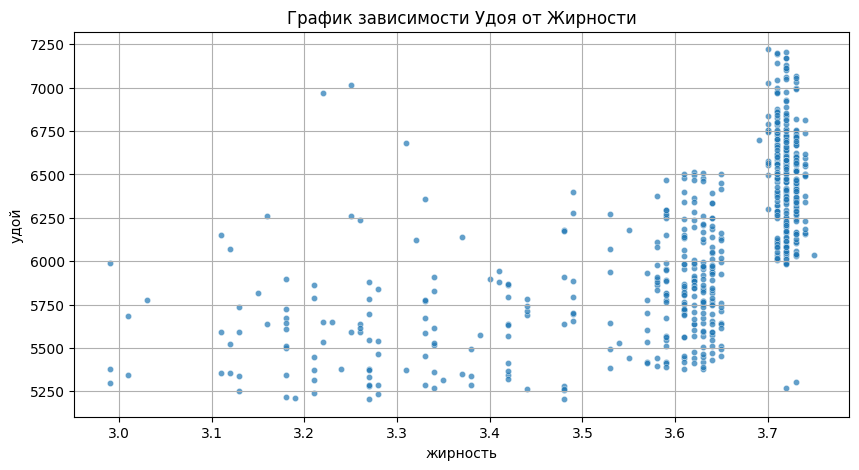

In [66]:
scatterplot(data_ferma, 'жирность', 'удой',title='График зависимости Удоя от Жирности')

In [ ]:
barplot(data_ferma, 'жирность', 'удой','График зависимости Удоя от Жирности', figsize=(22,8))

В среднем удой более 6000 кг достигается при жирности >= 3.69%.


In [ ]:
plt.figure(figsize=(22,8))
sns.countplot(data=data_ferma, x='жирность', hue='вкус_молока',palette = {'вкусно': 'green', 'не вкусно': 'red'})
plt.title('Частота распределения жирности в разделении по вкусу молока ')
plt.grid()
plt.show()

При жирности >= 3.9 преобладает вкусное молоко.

В остальном примерно одинаковое распределение.

In [ ]:
barplot(data_ferma, 'белок', 'удой','График зависимости Удоя от Белка')


Сложно сказать о какой-то зависимости. Распределение близко к константе.

Удой от 6000 кг в среднем наблюдается при проценте белка от 3.071 до 3.082.

In [ ]:
plt.figure(figsize=(12,5))
sns.countplot(data=data_ferma, x='белок', hue='вкус_молока',palette = {'вкусно': 'green', 'не вкусно': 'red'})
plt.title('Частота распределения белка в разделении по вкусу молока ')
plt.grid()
plt.show()

1. При белке < 3.073 преобладает невкусное молоко.
2. При белке = 3.073 вкусного и невкусного молока поровну.
3. При белке > 3.073 вкусное молоко доминирует.

In [ ]:
barplot(data_ferma, 'возраст', 'удой','График зависимости Удоя от возраста')

Коровы, возрастом менее 2 лет приносят намного меньше молока, чем коровы старше 2 лет.

In [ ]:
barplot(data_ferma, 'имя_папы', 'удой','График зависимости Удоя от имени папы')

Наиболее удойные коровы, чей папа - `Буйный` или `Геркулес`, они стабильно приносят более 6000 кг удоя.

Коровы, чей папа носит имя- `Барин`, в среднем не достигают 6000 кг удоя.

А коровы, чей папа носит имя- `Соловчик`, в среднем достигают около 6000 кг удоя.

#Строим модель для прогноза удоя коровы.

<h2>Разобьём выборку на тестовую и тренировочную.</h2>

In [ ]:
X = data_ferma.drop(columns=['удой','вкус_молока'])
y = data_ferma['удой']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

<h2>Обработка категориальных признаков.</h2>

<h2>Напишем функцию <code>Ohe-hot кодирования</code></h2>
и применим её к `X_train`, `X_test`, а затем и к `data_cow_buy`.

In [ ]:
def onehotencoding(data: pd.DataFrame, categorical_features: list[str], encoder: OneHotEncoder, type_='train') -> pd.DataFrame :
  if type_=='train':
    data_encoded = pd.DataFrame(
    encoder.fit_transform(
        data[categorical_features]),
     columns=encoder.get_feature_names_out(categorical_features)
     )
  else:
    data_encoded = pd.DataFrame(
    encoder.transform(
        data[categorical_features]),
     columns=encoder.get_feature_names_out(categorical_features)
     )
  data = pd.concat(
    [data.reset_index(drop=True).drop(categorical_features, axis=1),
     data_encoded], axis=1)
  return data

Применим для `X_test` и `X_train`.

In [ ]:
categorical_features = ['порода', 'тип_пастбища','порода_папы_быка','возраст','имя_папы']
encoder = OneHotEncoder(sparse_output=False, drop='first')
X_train = onehotencoding(X_train,categorical_features,encoder)
X_test = onehotencoding(X_test,categorical_features,encoder, type_='test')

<h2>Нормализация данных при помощи `StandardScaler`.</h2>

In [ ]:
numerical_features = ['эке','сырой_протеин',	'спо',	'жирность',	'белок']
standart = StandardScaler()

X_train[numerical_features] = standart.fit_transform(X_train[numerical_features])
X_test[numerical_features] = standart.transform(X_test[numerical_features])

<h2>Модель линейной регрессии.</h2>

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

metrics_df = pd.DataFrame({
    'R^2': {
        'train': r2_score(y_train, y_train_pred),
        'test': r2_score(y_test, y_test_pred)
    },
    'RMSE': {
        'train': mean_squared_error(y_train, y_train_pred, squared=False),
        'test': mean_squared_error(y_test, y_test_pred, squared=False)
    },
    'MAE': {
        'train': mean_absolute_error(y_train, y_train_pred),
        'test': mean_absolute_error(y_test, y_test_pred)
    }
})

metrics_df

<h2>Остатки на тренировочных и тестовых данных:</h2>

In [ ]:
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

Напишем функция для графиков остатков:

1. `plot_residuals` - график остатков.
2. `plot_hist_residual` - гистограмма распределения остатков.
3. `plot_qq_residual` - Q-Q график остатков.

`plot_all_plots_residual` - выводит одновременно 3 вышеперечисленные графика.

In [ ]:
def plot_residuals(y_pred,residuals, type_='train'):
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Остатки')
    if type_ == 'test':
      plt.title(f'График остатков на тестовых данных')
    else:
      plt.title(f'График остатков на тренировочных данных')


In [ ]:
def plot_hist_residual(residuals, type_='train'):
    sns.histplot(residuals, kde=True, bins=20)
    plt.xlabel('Остатки')
    if type_ == 'test':
      plt.title(f'Гистограмма остатков на тестовых данных')
    else:
      plt.title(f'Гистограмма остатков на тренировочных данных')


In [ ]:
def plot_qq_residual(residuals, type_='train'):
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.xlabel('Квантили остатков')
    if type_ == 'test':
      plt.title(f'Q-Q график остатков на тестовых данных')
    else:
      plt.title(f'Q-Q график остатков на тренировочных данных')


In [ ]:
def plot_all_plots_residual(y_pred, residuals, type_='train'):
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 3, 1)
    plot_residuals(y_pred,residuals, type_)
    plt.subplot(1, 3, 2)
    plot_hist_residual(residuals, type_)
    plt.subplot(1, 3, 3)
    plot_qq_residual(residuals, type_)
    plt.tight_layout()
    plt.show()

In [ ]:
plot_all_plots_residual(y_train_pred,train_residuals,'train')

In [ ]:
plot_all_plots_residual(y_test_pred,test_residuals,'test')

Распределение остатков нормальное, что на тренировочных данных, что на тестовых(имеются пару выбросов).

<h2>Посмотрим на величину коэффициентов модели. </h2>

In [ ]:
coefs = pd.DataFrame(index = np.array(X_train.columns))
coefs['lr'] = lr.coef_

coefs

Коэффициенты небольшие. Вероятно, переобучения нет.

In [ ]:
metrics_df

Разница между `train` и `test` не очень большая, коэффициенты небольшие, значит переобучение маловероятно.

Но сама точность не высокая, поэтому:
1. Построим еще одну линейную модель lr_2, в которой изменим нелинейные признаки.
2. Применим регуляризацию L1 для повышения точности и избавления от лишних признаков.
3. Удалим лишние признаки и итоговая модель будет `lasso`.

<h1>lr_2</h1>

<h2>Обработаем нелинейные признаки:</h2>


<h2>1. <code>эке</code> заменим на <code>эке^2</code>.</h2>


In [ ]:
X_train_2, X_test_2, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_2['эке^2'] = X_train_2['эке']**2
X_test_2['эке^2'] = X_test_2['эке']**2
X_train_2 = X_train_2.drop(columns=['эке'])
X_test_2 = X_test_2.drop(columns=['эке'])

<h2>2.<code>спо</code> сделаем категориальным признаком.</h2> Граница разделения - 0.91.

In [ ]:
X_train_2['спо'] = np.where(
    X_train_2['спо'] < 0.91, 'low', 'high'
)
X_test_2['спо'] = np.where(
    X_test_2['спо'] < 0.91, 'low', 'high'
)

In [ ]:
categorical_features_2 = ['порода', 'тип_пастбища','порода_папы_быка','возраст','имя_папы', 'спо']
encoder_2 = OneHotEncoder(sparse_output=False, drop='first')
X_train_2 = onehotencoding(X_train_2,categorical_features_2,encoder_2)
X_test_2 = onehotencoding(X_test_2,categorical_features_2,encoder_2,'test')

In [ ]:
numerical_features_2 = ['эке^2','сырой_протеин','жирность',	'белок']
standart_2 = StandardScaler()

X_train_2[numerical_features_2] = standart_2.fit_transform(X_train_2[numerical_features_2])
X_test_2[numerical_features_2] = standart_2.transform(X_test_2[numerical_features_2])

In [ ]:
lr_2 = LinearRegression()
lr_2.fit(X_train_2, y_train)

y_train_pred_2 = lr_2.predict(X_train_2)
y_test_pred_2 = lr_2.predict(X_test_2)

metrics_df_2 = pd.DataFrame({
    'R^2': {
        'train': r2_score(y_train, y_train_pred_2),
        'test': r2_score(y_test, y_test_pred_2)
    },
    'RMSE': {
        'train': mean_squared_error(y_train, y_train_pred_2, squared=False),
        'test': mean_squared_error(y_test, y_test_pred_2, squared=False)
    },
    'MAE': {
        'train': mean_absolute_error(y_train, y_train_pred_2),
        'test': mean_absolute_error(y_test, y_test_pred_2)
    }
})

metrics_df_2

Качество явно улучшилось, но это не предел.

In [ ]:
coefs_2 = pd.DataFrame(index = np.array(X_train_2.columns))

coefs_2['lr_2'] = lr_2.coef_

coefs_all = coefs.join(coefs_2, how='outer').fillna(0)

coefs_all

<h2>Lasso</h2>

In [ ]:
lasso_cv = LassoCV(cv=5, random_state=42,max_iter=10000)
lasso_cv.fit(X_train_2, y_train)
best_alpha = lasso_cv.alphas_[np.argmin(np.mean(lasso_cv.mse_path_,axis=1))]
print(f'Лучшее значение alpha: {best_alpha}')
print(f'R^2 на train: {r2_score(y_train,lasso_cv.predict(X_train_2))}')
print(f'R^2 на test: {r2_score(y_test,lasso_cv.predict(X_test_2))}')

Точность на `test` повысилась.

In [ ]:
coefs_3 = pd.DataFrame(index = np.array(X_train_2.columns))

coefs_3['lasso'] = lasso_cv.coef_

coefs_all = coefs_all.join(coefs_3, how='outer').fillna(0)

coefs_all.sort_values(by='lasso', ascending=False)

При помощи `Lasso`, можно исключить признаки: `порода_РефлешнСоверинг` и `порода_папы_быка_Соверин`.

In [ ]:
X_train_3 = X_train_2.drop(columns=['порода_РефлешнСоверинг','порода_папы_быка_Соверин'])
X_test_3 = X_test_2.drop(columns=['порода_РефлешнСоверинг','порода_папы_быка_Соверин'])

lasso = Lasso(best_alpha).fit(X_train_3, y_train)

<h2>Выберем лучшую модель </h2>

In [ ]:
metrics_df = pd.DataFrame(
    {
    'Model': ['LR','LR2', 'Lasso_CV', 'Lasso'],
    'RMSE (Train)': [
        mean_squared_error(y_train, lr.predict(X_train))**0.5,
        mean_squared_error(y_train, lr_2.predict(X_train_2))**0.5,
        mean_squared_error(y_train, lasso_cv.predict(X_train_2))**0.5,
        mean_squared_error(y_train, lasso.predict(X_train_3))**0.5
    ],
    'RMSE (Test)': [
        mean_squared_error(y_test, lr.predict(X_test))**0.5,
        mean_squared_error(y_test, lr_2.predict(X_test_2))**0.5,
        mean_squared_error(y_test, lasso_cv.predict(X_test_2))**0.5,
        mean_squared_error(y_test, lasso.predict(X_test_3))**0.5
    ],
    'MAE (Train)': [
        mean_absolute_error(y_train, lr.predict(X_train)),
        mean_absolute_error(y_train, lr_2.predict(X_train_2)),
        mean_absolute_error(y_train, lasso_cv.predict(X_train_2)),
        mean_absolute_error(y_train, lasso.predict(X_train_3))
    ],
    'MAE (Test)': [
        mean_absolute_error(y_test, lr.predict(X_test)),
        mean_absolute_error(y_test, lr_2.predict(X_test_2)),
        mean_absolute_error(y_test, lasso_cv.predict(X_test_2)),
        mean_absolute_error(y_test, lasso.predict(X_test_3))
    ],
    'R2 (Train)': [
        r2_score(y_train, lr.predict(X_train)),
        r2_score(y_train, lr_2.predict(X_train_2)),
        r2_score(y_train, lasso_cv.predict(X_train_2)),
        r2_score(y_train, lasso.predict(X_train_3))
    ],
    'R2 (Test)': [
        r2_score(y_test, lr.predict(X_test)),
        r2_score(y_test, lr_2.predict(X_test_2)),
        r2_score(y_test, lasso_cv.predict(X_test_2)),
        r2_score(y_test, lasso.predict(X_test_3))
    ]
}
)

metrics_df

Целесообразнее использовать модель `lasso`. Она обладает наивысшей точностью и минимальным набором признаков.

In [ ]:
y_train_pred_lasso = lasso.predict(X_train_3)
y_test_pred_lasso  = lasso.predict(X_test_3)
train_residuals_lasso = y_train - y_train_pred_lasso
test_residuals_lasso = y_test - y_test_pred_lasso

In [ ]:
plot_all_plots_residual(y_train_pred_lasso,train_residuals_lasso,'train')

In [ ]:
plot_all_plots_residual(y_test_pred_lasso,test_residuals_lasso,'test')

Анализ остатков свидетельствует о том, что модель обучена корректно, распределение нормальное, предположение о гомоскедастичности выполнено.

Предобработаем `data_cow_buy_model` для применения модели `lasso`.

In [ ]:
data_cow_buy_model = data_cow_buy.copy()
#Изменение нелинейных признаков
data_cow_buy_model['эке^2'] = data_cow_buy_model['эке']**2
data_cow_buy_model = data_cow_buy_model.drop(columns=['эке'])
data_cow_buy_model['спо'] = np.where(
    data_cow_buy_model['спо'] < 0.91, 'low', 'high'
)
#one-hot-encoding
data_cow_buy_model = onehotencoding(data_cow_buy_model,categorical_features_2,encoder_2, 'test')
#удалям ненужные столбцы
data_cow_buy_model = data_cow_buy_model.drop(columns=['порода_РефлешнСоверинг','порода_папы_быка_Соверин'])
#нормализация численных столбцов
data_cow_buy_model[numerical_features_2] = standart_2.transform(data_cow_buy_model[numerical_features_2])
#одинаковый порядок столбцов
data_cow_buy_model = data_cow_buy_model[X_train_3.columns]

Сделаем прогноз для новых данных.

In [ ]:
data_cow_buy_predict = np.round(lasso.predict(data_cow_buy_model)).astype(int)

# <h2>Строим модель для прогноза вкусности молока</h2>


In [ ]:
X = data_ferma.drop(columns=['вкус_молока', 'удой'])
y = data_ferma['вкус_молока'].replace({'вкусно': 1, 'не вкусно': 0})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
y.value_counts() / y.shape[0]

In [ ]:
y_train.value_counts() / y_train.shape[0], y_test.value_counts() / y_test.shape[0]

Пропорции примерно сохраняются.

In [ ]:
categorical_features = ['порода', 'тип_пастбища','порода_папы_быка','возраст','имя_папы']
encoder = OneHotEncoder(sparse_output=False, drop='first')
X_train = onehotencoding(X_train,categorical_features,encoder)
X_test = onehotencoding(X_test,categorical_features,encoder, type_='test')

In [ ]:
numerical_features = ['эке','сырой_протеин',	'спо',	'жирность',	'белок']
standart = StandardScaler()

X_train[numerical_features] = standart.fit_transform(X_train[numerical_features])
X_test[numerical_features] = standart.transform(X_test[numerical_features])

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

In [ ]:
probs = logreg.predict_proba(X_test)[:,1]
roc_auc_score(y_test, probs)

<h3>Построим вторую модель <code>logreg_2</code> с преобразованием нелинейных признаков. </h3>

In [ ]:
X = data_ferma.drop(columns=['вкус_молока', 'удой'])
y = data_ferma['вкус_молока'].replace({'вкусно': 1, 'не вкусно': 0})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train['эке^2'] = X_train['эке']**2
X_test['эке^2'] = X_test['эке']**2
X_train = X_train.drop(columns=['эке'])
X_test = X_test.drop(columns=['эке'])

In [ ]:
X_train['спо'] = np.where(
    X_train['спо'] < 0.91, 'low', 'high'
)
X_test['спо'] = np.where(
    X_test['спо'] < 0.91, 'low', 'high'
)

In [ ]:
categorical_features = ['порода', 'тип_пастбища','порода_папы_быка','возраст','имя_папы','спо']
encoder = OneHotEncoder(sparse_output=False, drop='first')
X_train = onehotencoding(X_train,categorical_features,encoder)
X_test = onehotencoding(X_test,categorical_features,encoder, type_='test')

In [ ]:
numerical_features = ['эке^2','сырой_протеин',	'жирность',	'белок']
standart = StandardScaler()

X_train[numerical_features] = standart.fit_transform(X_train[numerical_features])
X_test[numerical_features] = standart.transform(X_test[numerical_features])

In [ ]:
logreg_2 = LogisticRegression()
logreg_2.fit(X_train, y_train)

y_pred_2 = logreg_2.predict(X_test)

In [ ]:
probs_2 = logreg_2.predict_proba(X_test)[:,1]
roc_auc_score(y_test, probs_2)

Качество заметно улучшилось.

In [ ]:
accuracy = accuracy_score(y_test, y_pred_2)
precision = precision_score(y_test, y_pred_2)
recall = recall_score(y_test, y_pred_2)
f1 = f1_score(y_test, y_pred_2)

metrics_df = pd.DataFrame({
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1': [f1]
}, index=['logreg'])

metrics_df

In [ ]:
cm = confusion_matrix(y_test, y_pred_2)
sns.heatmap(cm, annot=True, cmap="vlag")
plt.ylabel('Действительное значение')
plt.xlabel('Предсказание');

Модель часто относит объекты класса 0 к объектам класса 1.

При покупке коров наиболее важно качество, а не количество, т.к. невкусное молоко продаваться не будет, значит будет издержкой, при этом рентабельность не
такая высокая, чтобы компенсировать эти издержки, а ресурсы ограниченны. Наиболее критична ложно-положительная ошибка. Будем, в первую очередь, стремиться увеличить метрику Precision.

In [ ]:
thresholds = np.linspace(0.5, 1, 101)
recalls = []
precisions = []
f1s = []

for threshold in thresholds:
    proba = (probs_2 > threshold).astype(int)
    recalls.append(recall_score(y_test, proba))
    precisions.append(precision_score(y_test, proba, zero_division=1))# zero_division=0 для предотвращения ошибки при делении на ноль
    f1s.append(f1_score(y_test, proba))

recalls = np.array(recalls)
precisions = np.array(precisions)
f1s = np.array(f1s)

In [ ]:
thresholds[precisions == 1].min()

In [ ]:
recalls[thresholds == 0.8400000000000001], f1s[thresholds == 0.8400000000000001]

Критическая ошибка(ложно-положительная) будет равна 0 при вероятности принадлежности к положительному классу 0.84.

`recall` будет равен 0.009, `f1_score` будет равен 0.019.

Такая метрика очень плохая, модель не распознаёт более 99% коров с вкусным молоком.

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()
plt.xticks(np.arange(0, 0.95, 0.05))
plt.show()

При `precision` > 0.8 есть `recall` > 0.4. Это является оптимальным значением, т.к. точность первостепенна, но при большой точности полнота слишком мала.

Найдём при каком отступе достигается такие значение

Найдем отступ `threshold`, где достигается максимальный recall при precision > 0.83.

In [ ]:
recalls[(precisions > 0.83 )].max()

In [ ]:
threshold =  thresholds[recalls == recalls[(precisions > 0.83 )].max()][0]

Будем использовать модель с `threshold` = 0.7.

In [ ]:
proba = (probs_2 > threshold).astype(int)
accuracy = accuracy_score(y_test, proba)
precision = precision_score(y_test, proba)
recall = recall_score(y_test, proba)
f1 = f1_score(y_test, proba)

metrics_df = pd.DataFrame({
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1': [f1]
}, index=['logreg'])

metrics_df

Таким образом, уверенность в ответе будет 83%, при этом модель будем выделять 41% коров с вкусным молоком.

# Применяем модели к `data_cow_buy` и отберём подходящих коров.

Применим модель для `data_cow_buy`.

In [ ]:
data_cow_taste = data_cow_buy.copy()
# Изменение нелинейных признаков
data_cow_taste['эке^2'] = data_cow_taste['эке']**2
data_cow_taste = data_cow_taste.drop(columns=['эке'])
data_cow_taste['спо'] = np.where(
    data_cow_taste['спо'] < 0.91, 'low', 'high'
)

In [ ]:
#Обработка численных и категориальных переменных
data_cow_taste = onehotencoding(data_cow_taste,categorical_features,encoder, type_='test')
data_cow_taste[numerical_features] = standart.transform(data_cow_taste[numerical_features])
#Нужный порядок столбцов
data_cow_taste = data_cow_taste[X_train.columns]

In [ ]:
data_cow_buy['удой'] = data_cow_buy_predict

In [ ]:
#Применяем логлосс модель к data_cow_buy
data_cow_proba = logreg_2.predict_proba(data_cow_taste)[:,1]
threshold = 0.7
proba = (data_cow_proba > threshold).astype(int)
data_cow_buy['вкус_молока'] = proba
data_cow_buy['вкус_молока'].replace({1: 'вкусно', 0: 'не вкусно'}, inplace=True)

<h3>Найдем подходящих коров</h3>

In [ ]:
data_cow_buy.query('вкус_молока == "вкусно" & удой > 6000')

Итого, найдено 3 коровы с вкусным молоком и удоем > 6000 кг в год.

Индексы: 0, 6, 9.

# Итоговый вывод

Для решения поставленной задачи были разработаны 2 модели машинного обучения:
* Для прогноза удоя коровы за год (в кг) - линейная регрессия
* Вкусности молока - логистическая регрессия

При помощи которых были сделаны предсказания и выявлены 3 потенциально наиболее выгодные коровы с удоем более 6000 кг в год и вкусным молоком.

Абсолютная ошибка первой модели(MAE) составляет порядка 140 кг в год.

Точность второй модели(вероятность правильного предсказания) составляет более 84% при охвате около 40% от всех коров с вкусным молоком.

Зная среднюю рентабельность с одной коровы можно изменить вторую модель, использую знания риск-менеджмента. Например, при высокой рентабельности можно опустить точность модели в пользу полноты, тем самым компенсируя качество количеством. И, наоборот, при низкой рентабельности ужесточить требования точности, уменьшив полноту.

В данной задаче были использованы такие способы улучшения качества регрессии:
1. Перевод категориальных признаков в бинарные.
2. Преобразование нелинейных признаков в линейные.
3. Перевод нелинейных признаков в категориальные.
4. Нормализация числовых признаков.

Результаты регрессионной модели можно улучшить, а именно, установить порог под конкретные рассчеты или нужную точность.

При анализе рисков или экономических рассчетов в первую очередь важны следующие метрики качества:
1. Precision(точность) - метрика, которая показывает долю правильно предсказанных объектов из всех, которые классификатор отнес к положительному классу. Характеризует уверенность модели в предсказании положительного класса.Это вероятность того, что объект, предсказанный моделью как положительный, действительно является положительным.
2. Recall(полнота) - метрика, которая показывает долю объектов, предсказанных как положительный класс среди всех объектов положительного класса.  Характеризует, сколько из всех объектов положительного класса модель смогла корректно выявить.


Рекомендация к заказчику: купить коров с индексами: 0, 6, 9.
